# 🔬 Semi-Supervised Learning for Toxicity Prediction
## Demonstrating the Power of SSL with Limited Labeled Data

---

### 🎯 **Objective**
This notebook demonstrates the **true power of semi-supervised learning** by:
- Training with **5661 labeled molecules** (balanced: 2817 toxic + 2844 non-toxic)
- Enhancing with **unlabeled molecules** from ZINC database
- Comparing performance against supervised baseline

### 💡 **Why This Matters**
In real-world drug discovery:
- **Labeled data is EXPENSIVE**: Toxicity testing costs millions, takes years
- **Unlabeled data is ABUNDANT**: Millions of known molecular structures
- **Semi-supervised learning bridges this gap** by leveraging unlabeled data

### 📊 **Experimental Setup**
- **Labeled Training Set**: ~3962 molecules (70% of 5661, stratified)
- **Test Set**: ~1698 molecules (30% of 5661, held out)
- **Unlabeled Enhancement**: Varying sizes from ZINC database
- **Target**: Toxic

### 🧪 **Methods Evaluated**
1. **Baseline**: Supervised only (limited labeled samples)
2. **Label Propagation**: Graph-based, hard labels
3. **Label Spreading**: Graph-based, soft labels  
4. **Self-Training**: Iterative pseudo-labeling with Random Forest

---

**Expected Outcome**: Semi-supervised methods should **significantly outperform** the baseline when labeled data is scarce!

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib
import json
import warnings
from time import time
from collections import Counter

warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("=" * 100)
print("SEMI-SUPERVISED LEARNING FOR TOXICITY PREDICTION (Tox21)")
print("=" * 100)
print("\n✓ Libraries imported successfully")
print("✓ Random seed set to:", RANDOM_STATE)

SEMI-SUPERVISED LEARNING FOR TOXICITY PREDICTION (Tox21)

✓ Libraries imported successfully
✓ Random seed set to: 42


In [2]:
print("\n" + "="*100)
print("STEP 1: LOADING PROCESSED DATA (Tox21)")
print("="*100)

# Load processed/enhanced datasets from tox21 pipeline
df_labeled = pd.read_csv('../../data/processed/tox21/labeled_processed.csv')
df_unlabeled = pd.read_csv('../../data/processed/tox21/unlabeled_processed.csv')

# Build feature info on the fly (exclude IDs/SMILES/target)
target_col = 'toxic'
id_cols = ['mol_id', 'smiles', 'canonical_smiles']
feature_cols = [c for c in df_labeled.columns if c not in id_cols + [target_col]]
feature_info = {
    "n_features": len(feature_cols),
    "feature_names": feature_cols
}

print(f"\n✓ Original labeled data: {df_labeled.shape}")
print(f"✓ Original unlabeled data: {df_unlabeled.shape}")
print(f"✓ Features: {feature_info['n_features']}")

tox_dist = df_labeled[target_col].value_counts().sort_index()
print(f"\n{'='*100}")
print("ORIGINAL LABELED DATA CLASS DISTRIBUTION")
print(f"{'='*100}")
print(f"\n{target_col.upper()}:")
print(f"  Class 0 (Non-Toxic): {tox_dist[0]} ({tox_dist[0]/len(df_labeled)*100:.1f}%)")
print(f"  Class 1 (Toxic):     {tox_dist[1]} ({tox_dist[1]/len(df_labeled)*100:.1f}%)")


STEP 1: LOADING PROCESSED DATA (Tox21)

✓ Original labeled data: (5660, 37)
✓ Original unlabeled data: (249453, 36)
✓ Features: 36

ORIGINAL LABELED DATA CLASS DISTRIBUTION

TOXIC:
  Class 0 (Non-Toxic): 2844 (50.2%)
  Class 1 (Toxic):     2816 (49.8%)


In [3]:
print("\n" + "="*100)
print("STEP 2: STRATEGIC DATA SPLITTING")
print("="*100)

X_full = df_labeled[feature_cols].values
y_tox_full = df_labeled[target_col].values

X_unlabeled_full = df_unlabeled[feature_cols].values

print(f"\nTotal available data:")
print(f"  Labeled:   {len(X_full):,} molecules")
print(f"  Unlabeled: {len(X_unlabeled_full):,} molecules")

X_train, X_test, y_tox_train, y_tox_test = train_test_split(
    X_full, y_tox_full,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y_tox_full
)

unlabeled_sizes = [0, 5000, 10000, 15000, 20000, 25000, 30000]
unlabeled_sizes = [min(n, X_unlabeled_full.shape[0]) for n in unlabeled_sizes]

print(f"\n{'='*100}")
print("TRAIN-TEST SPLIT (70-30)")
print(f"{'='*100}")
print(f"  Training set: {len(X_train):,} molecules")
print(f"  Test set:     {len(X_test):,} molecules")

tox_train_dist = Counter(y_tox_train)
tox_test_dist = Counter(y_tox_test)

print(f"\n{target_col.upper()} distribution in TRAINING set:")
print(f"  Class 0 (Non-Toxic): {tox_train_dist[0]} ({tox_train_dist[0]/len(X_train)*100:.1f}%)")
print(f"  Class 1 (Toxic):     {tox_train_dist[1]} ({tox_train_dist[1]/len(X_train)*100:.1f}%)")
print(f"  Balance ratio: {min(tox_train_dist[0], tox_train_dist[1]) / max(tox_train_dist[0], tox_train_dist[1]):.2f}")

print(f"\n{target_col.upper()} distribution in TEST set:")
print(f"  Class 0 (Non-Toxic): {tox_test_dist[0]} ({tox_test_dist[0]/len(X_test)*100:.1f}%)")
print(f"  Class 1 (Toxic):     {tox_test_dist[1]} ({tox_test_dist[1]/len(X_test)*100:.1f}%)")

print(f"\n{'='*100}")
print("UNLABELED DATA SIZES TO TEST")
print(f"{'='*100}")
for size in unlabeled_sizes:
    if size == 0:
        print(f"  • {size:6d} molecules (Baseline - supervised only)")
    else:
        print(f"  • {size:6d} molecules")

print(f"\n{'='*100}")
print("FINAL DATASET SUMMARY")
print(f"{'='*100}")
print(f"  Training (labeled):    {len(X_train):,} molecules")
print(f"  Testing:               {len(X_test):,} molecules")
print(f"  Unlabeled (available): {len(X_unlabeled_full):,} molecules")
print(f"\n✓ Data splitting completed with stratification")
print(f"✓ Classes are balanced in both train and test sets")


STEP 2: STRATEGIC DATA SPLITTING

Total available data:
  Labeled:   5,660 molecules
  Unlabeled: 249,453 molecules

TRAIN-TEST SPLIT (70-30)
  Training set: 3,962 molecules
  Test set:     1,698 molecules

TOXIC distribution in TRAINING set:
  Class 0 (Non-Toxic): 1991 (50.3%)
  Class 1 (Toxic):     1971 (49.7%)
  Balance ratio: 0.99

TOXIC distribution in TEST set:
  Class 0 (Non-Toxic): 853 (50.2%)
  Class 1 (Toxic):     845 (49.8%)

UNLABELED DATA SIZES TO TEST
  •      0 molecules (Baseline - supervised only)
  •   5000 molecules
  •  10000 molecules
  •  15000 molecules
  •  20000 molecules
  •  25000 molecules
  •  30000 molecules

FINAL DATASET SUMMARY
  Training (labeled):    3,962 molecules
  Testing:               1,698 molecules
  Unlabeled (available): 249,453 molecules

✓ Data splitting completed with stratification
✓ Classes are balanced in both train and test sets


In [4]:
print("\n" + "="*100)
print("STEP 3: DEFINING HELPER FUNCTIONS")
print("="*100)

def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'F1-Score': f1_score(y_true, y_pred, zero_division=0),
    }
    if y_pred_proba is not None:
        try:
            unique_probs = np.unique(y_pred_proba)
            if len(unique_probs) > 2 and not np.all((y_pred_proba == 0) | (y_pred_proba == 1)):
                metrics['ROC-AUC'] = roc_auc_score(y_true, y_pred_proba)
                metrics['PR-AUC'] = average_precision_score(y_true, y_pred_proba)
            else:
                metrics['ROC-AUC'] = np.nan
                metrics['PR-AUC'] = np.nan
        except Exception:
            metrics['ROC-AUC'] = np.nan
            metrics['PR-AUC'] = np.nan
    else:
        metrics['ROC-AUC'] = np.nan
        metrics['PR-AUC'] = np.nan
    return metrics

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", labels=['Non-Toxic', 'Toxic']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=labels, yticklabels=labels,
                annot_kws={'size': 14, 'weight': 'bold'})
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')
    plt.ylabel('Actual', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=14, fontweight='bold', pad=15)
    total = cm.sum()
    for i in range(2):
        for j in range(2):
            plt.text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)',
                     ha='center', va='center', fontsize=10, color='gray')
    plt.tight_layout()
    plt.show()
    return cm

print("\n✓ Helper functions defined:")
print("  - evaluate_model(): Compute accuracy, precision, recall, F1, ROC-AUC, PR-AUC")
print("  - plot_confusion_matrix(): Visualize classification results")


STEP 3: DEFINING HELPER FUNCTIONS

✓ Helper functions defined:
  - evaluate_model(): Compute accuracy, precision, recall, F1, ROC-AUC, PR-AUC
  - plot_confusion_matrix(): Visualize classification results



STEP 4: BASELINE MODEL (SUPERVISED LEARNING)

Training supervised model with 3962 labeled molecules
This establishes our performance benchmark

TRAINING BASELINE: RANDOM FOREST (3962 labeled samples)

[Tox21 - TOXIC]
  Training on 3962 samples... Done in 0.34s

  Results:
    Accuracy:  0.6979
    Precision: 0.7145
    Recall:    0.6544
    F1-Score:  0.6831
    ROC-AUC:   0.7691

  Confusion Matrix:


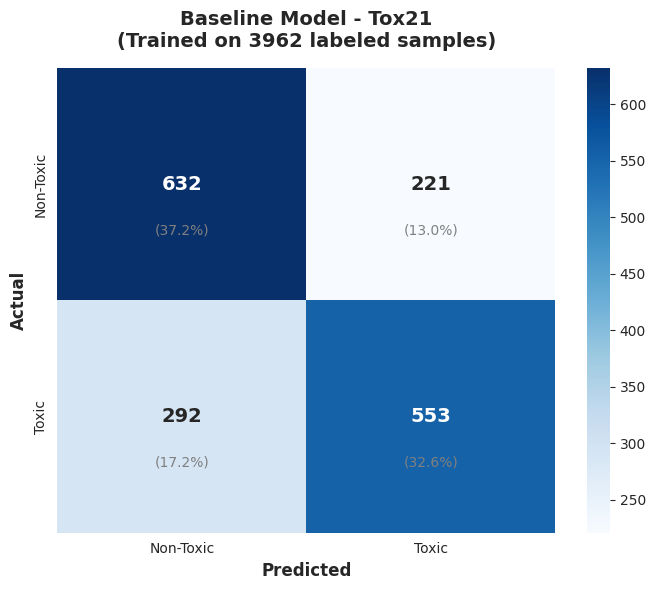


BASELINE BENCHMARK:
  Tox21 F1-Score: 0.6831
  Tox21 ROC-AUC:  0.7691

 Note: This is our starting point with supervised learning only
   Semi-supervised methods should improve upon this baseline.

ORDERING UNLABELED DATA BY UNCERTAINTY

📊 Using baseline model to predict on 249,453 unlabeled samples...
✓ Unlabeled data ordered by uncertainty
  Most uncertain samples (top 5 uncertainty scores): [5.90342867e-07 7.76460526e-07 2.92638396e-06 4.19906202e-06
 5.26666469e-06]
  Least uncertain samples (bottom 5 uncertainty scores): [0.43281405 0.43467686 0.43606774 0.43606774 0.44627556]

💡 From now on, all semi-supervised methods will use the MOST UNCERTAIN samples first


In [6]:
print("\n" + "="*100)
print("STEP 4: BASELINE MODEL (SUPERVISED LEARNING)")
print("="*100)
print(f"\nTraining supervised model with {len(X_train)} labeled molecules")
print("This establishes our performance benchmark")
baseline_results_tox = []
print(f"\n{'='*100}")
print(f"TRAINING BASELINE: RANDOM FOREST ({len(X_train)} labeled samples)")
print(f"{'='*100}")
print(f"\n[Tox21 - TOXIC]")
print(f"  Training on {len(X_train)} samples...", end=' ')
start_time = time()
baseline_tox = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5,
    n_jobs=-1
)
baseline_tox.fit(X_train, y_tox_train)
train_time = time() - start_time
print(f"Done in {train_time:.2f}s")
y_pred = baseline_tox.predict(X_test)
y_pred_proba = baseline_tox.predict_proba(X_test)[:, 1]
metrics_tox = evaluate_model(y_tox_test, y_pred, y_pred_proba, f"Baseline ({len(X_train)} labeled)")
metrics_tox['Training_Time'] = train_time
metrics_tox['N_Unlabeled'] = 0
metrics_tox['N_Train'] = len(X_train)
baseline_results_tox.append(metrics_tox)
print(f"\n  Results:")
print(f"    Accuracy:  {metrics_tox['Accuracy']:.4f}")
print(f"    Precision: {metrics_tox['Precision']:.4f}")
print(f"    Recall:    {metrics_tox['Recall']:.4f}")
print(f"    F1-Score:  {metrics_tox['F1-Score']:.4f}")
print(f"    ROC-AUC:   {metrics_tox['ROC-AUC']:.4f}")
best_baseline_tox = metrics_tox['F1-Score']
print(f"\n  Confusion Matrix:")
cm = plot_confusion_matrix(y_tox_test, y_pred,
                          title=f"Baseline Model - Tox21\n(Trained on {len(X_train)} labeled samples)",
                          labels=['Non-Toxic', 'Toxic'])
print(f"\n{'='*100}")
print(f"BASELINE BENCHMARK:")
print(f"  Tox21 F1-Score: {best_baseline_tox:.4f}")
print(f"  Tox21 ROC-AUC:  {metrics_tox['ROC-AUC']:.4f}")
print(f"{'='*100}")
print("\n Note: This is our starting point with supervised learning only")
print("   Semi-supervised methods should improve upon this baseline.")
# ============================================================================
# NEW: ORDER UNLABELED DATA BY UNCERTAINTY
# ============================================================================
print(f"\n{'='*100}")
print("ORDERING UNLABELED DATA BY UNCERTAINTY")
print(f"{'='*100}")
print(f"\n📊 Using baseline model to predict on {len(X_unlabeled_full):,} unlabeled samples...")
baseline_unlabeled_proba = baseline_tox.predict_proba(X_unlabeled_full)[:, 1]
# Calculate uncertainty (distance from 0.5 = most uncertain)
uncertainty = np.abs(baseline_unlabeled_proba - 0.5)
# Sort by uncertainty (ascending = most uncertain first)
uncertain_indices = np.argsort(uncertainty)
# Reorder unlabeled data by uncertainty
X_unlabeled_ordered = X_unlabeled_full[uncertain_indices]
print(f"✓ Unlabeled data ordered by uncertainty")
print(f"  Most uncertain samples (top 5 uncertainty scores): {uncertainty[uncertain_indices[:5]]}")
print(f"  Least uncertain samples (bottom 5 uncertainty scores): {uncertainty[uncertain_indices[-5:]]}")
print(f"\n💡 From now on, all semi-supervised methods will use the MOST UNCERTAIN samples first")

In [7]:
print("\n" + "="*100)
print("STEP 5: LABEL PROPAGATION (Graph-Based Semi-Supervised)")
print("="*100)
results_lp_tox = []
unlabeled_sizes = [15000, 20000, 25000, 30000]
unlabeled_sizes = [min(n, X_unlabeled_ordered.shape[0]) for n in unlabeled_sizes]
for idx, n_unlabeled in enumerate(unlabeled_sizes):
    print(f"\n{'='*100}")
    print(f"[{idx+1}/{len(unlabeled_sizes)}] Testing with {n_unlabeled:,} unlabeled samples")
    print(f"{'='*100}")
    if n_unlabeled == 0:
        print("  Skipping (n=0 is baseline)")
        continue
    # Use pre-ordered unlabeled data (most uncertain first)
    X_unlabeled = X_unlabeled_ordered[:n_unlabeled]
    X_combined = np.vstack([X_train, X_unlabeled])
    print(f"\n  [Label Propagation - Tox21]")
    y_tox_combined = np.concatenate([y_tox_train, np.full(len(X_unlabeled), -1)])
    print(f"    Training on {len(X_train)} labeled + {len(X_unlabeled):,} unlabeled (most uncertain)...", end=' ')
    start_time = time()
    n_features = X_train.shape[1]
    optimal_gamma = 1.0 / n_features
    lp_tox = LabelPropagation(
        kernel='rbf',
        gamma=optimal_gamma,
        max_iter=1000,
        n_jobs=-1
    )
    lp_tox.fit(X_combined, y_tox_combined)
    train_time = time() - start_time
    print(f"Done in {train_time:.2f}s")
    y_pred = lp_tox.predict(X_test)
    y_pred_proba = lp_tox.predict_proba(X_test)[:, 1]
    n_nan = np.sum(np.isnan(y_pred_proba))
    if n_nan > 0:
        print(f"    WARNING: {n_nan}/{len(y_pred_proba)} NaN probabilities detected")
        y_pred_proba = np.nan_to_num(y_pred_proba, nan=0.5)
    metrics = evaluate_model(y_tox_test, y_pred, y_pred_proba,
                            f"LabelPropagation (n={n_unlabeled})")
    metrics['Training_Time'] = train_time
    metrics['N_Unlabeled'] = n_unlabeled
    metrics['N_Train'] = len(X_train)
    metrics['Gamma'] = optimal_gamma
    results_lp_tox.append(metrics)
    roc_str = f"{metrics['ROC-AUC']:.4f}" if not np.isnan(metrics['ROC-AUC']) else "N/A"
    print(f"    Accuracy: {metrics['Accuracy']:.4f} | F1: {metrics['F1-Score']:.4f} | ROC-AUC: {roc_str}")
    improvement = ((metrics['F1-Score'] - best_baseline_tox) / best_baseline_tox) * 100
    print(f"   Improvement over baseline: {improvement:+.2f}%")
lp_df_tox = pd.DataFrame(results_lp_tox)
print(f"\n{'='*100}")
print("LABEL PROPAGATION RESULTS SUMMARY")
print(f"{'='*100}")
print("\n>>> Tox21 <<<")
print(lp_df_tox[['Model', 'N_Unlabeled', 'Accuracy', 'F1-Score', 'ROC-AUC', 'Gamma']].to_string(index=False))


STEP 5: LABEL PROPAGATION (Graph-Based Semi-Supervised)

[1/4] Testing with 15,000 unlabeled samples

  [Label Propagation - Tox21]
    Training on 3962 labeled + 15,000 unlabeled (most uncertain)... Done in 159.11s
    Accuracy: 0.6219 | F1: 0.6844 | ROC-AUC: 0.7047
   Improvement over baseline: +0.18%

[2/4] Testing with 20,000 unlabeled samples

  [Label Propagation - Tox21]
    Training on 3962 labeled + 20,000 unlabeled (most uncertain)... Done in 253.26s
    Accuracy: 0.6143 | F1: 0.6944 | ROC-AUC: 0.7044
   Improvement over baseline: +1.64%

[3/4] Testing with 25,000 unlabeled samples

  [Label Propagation - Tox21]
    Training on 3962 labeled + 25,000 unlabeled (most uncertain)... Done in 398.76s
    Accuracy: 0.5966 | F1: 0.6916 | ROC-AUC: 0.7041
   Improvement over baseline: +1.24%

[4/4] Testing with 30,000 unlabeled samples

  [Label Propagation - Tox21]
    Training on 3962 labeled + 30,000 unlabeled (most uncertain)... Done in 579.91s
    Accuracy: 0.5724 | F1: 0.6832 | 

In [ ]:
print("\n" + "="*100)
print("STEP 6: SELF-TRAINING (Iterative Pseudo-Labeling)")
print("="*100)
results_st_tox = []
unlabeled_sizes = [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]
unlabeled_sizes = [min(n, X_unlabeled_ordered.shape[0]) for n in unlabeled_sizes]
for idx, n_unlabeled in enumerate(unlabeled_sizes):
    print(f"\n{'='*100}")
    print(f"[{idx+1}/{len(unlabeled_sizes)}] Testing with {n_unlabeled:,} unlabeled samples")
    print(f"{'='*100}")
    if n_unlabeled == 0:
        print("  Skipping (n=0 is baseline)")
        continue
    # Use pre-ordered unlabeled data (most uncertain first)
    X_unlabeled = X_unlabeled_ordered[:n_unlabeled]
    X_combined = np.vstack([X_train, X_unlabeled])
    print(f"\n  [Self-Training (RandomForest) - Tox21]")
    y_tox_combined = np.concatenate([y_tox_train, np.full(len(X_unlabeled), -1)])
    print(f"    Training on {len(X_train)} labeled + {len(X_unlabeled):,} unlabeled (most uncertain)...", end=' ')
    start_time = time()
    st_tox = SelfTrainingClassifier(
        base_estimator=RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
        threshold=0.75,
        max_iter=10,
        verbose=False
    )
    st_tox.fit(X_combined, y_tox_combined)
    train_time = time() - start_time
    print(f"Done in {train_time:.2f}s")
    n_labeled = (st_tox.transduction_ != -1).sum() - len(y_tox_train)
    print(f"    📝 Pseudo-labeled {n_labeled}/{n_unlabeled} samples ({n_labeled/n_unlabeled*100:.1f}%)")
    y_pred = st_tox.predict(X_test)
    y_pred_proba = st_tox.predict_proba(X_test)[:, 1]
    metrics = evaluate_model(y_tox_test, y_pred, y_pred_proba,
                            f"SelfTraining-RF (n={n_unlabeled})")
    metrics['Training_Time'] = train_time
    metrics['N_Unlabeled'] = n_unlabeled
    metrics['N_Train'] = len(X_train)
    metrics['N_Pseudo_Labeled'] = n_labeled
    results_st_tox.append(metrics)
    print(f"    Accuracy: {metrics['Accuracy']:.4f} | F1: {metrics['F1-Score']:.4f} | ROC-AUC: {metrics['ROC-AUC']:.4f}")
    improvement = ((metrics['F1-Score'] - best_baseline_tox) / best_baseline_tox) * 100
    print(f"    Improvement over baseline: {improvement:+.2f}%")
st_df_tox = pd.DataFrame(results_st_tox)
print(f"\n{'='*100}")
print("SELF-TRAINING RESULTS SUMMARY")
print(f"{'='*100}")
print("\n>>> Tox21 <<<")
print(st_df_tox[['Model', 'N_Unlabeled', 'N_Pseudo_Labeled', 'Accuracy', 'F1-Score', 'ROC-AUC']].to_string(index=False))


STEP 6: SELF-TRAINING (Iterative Pseudo-Labeling)

[1/8] Testing with 5,000 unlabeled samples

  [Self-Training (RandomForest) - Tox21]
    Training on 3962 labeled + 5,000 unlabeled... Done in 7.64s
    📝 Pseudo-labeled 4369/5000 samples (87.4%)
    Accuracy: 0.7032 | F1: 0.6870 | ROC-AUC: 0.7541
    💪 Improvement over baseline: +0.56%

[2/8] Testing with 10,000 unlabeled samples

  [Self-Training (RandomForest) - Tox21]
    Training on 3962 labeled + 10,000 unlabeled... Done in 11.41s
    📝 Pseudo-labeled 9200/10000 samples (92.0%)
    Accuracy: 0.7067 | F1: 0.6941 | ROC-AUC: 0.7547
    💪 Improvement over baseline: +1.61%

[3/8] Testing with 15,000 unlabeled samples

  [Self-Training (RandomForest) - Tox21]
    Training on 3962 labeled + 15,000 unlabeled... Done in 15.69s
    📝 Pseudo-labeled 14177/15000 samples (94.5%)
    Accuracy: 0.6920 | F1: 0.6774 | ROC-AUC: 0.7477
    💪 Improvement over baseline: -0.85%

[4/8] Testing with 20,000 unlabeled samples

  [Self-Training (RandomFor

In [ ]:
print("\n" + "="*100)
print("STEP 7: ROBUST CO-TRAINING (Full Feature Set & Multi-View)")
print("="*100)

unlabeled_sizes = [5000, 10000, 15000, 20000, 25000,30000,35000,40000]
unlabeled_sizes = [min(n, X_unlabeled_full.shape[0]) for n in unlabeled_sizes]

view1_candidates = [
    'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'NumValenceElectrons',
    'TPSA', 'MaxPartialCharge', 'MinPartialCharge', 'LabuteASA', 'MolMR',
    'QED', 'NumHeteroatoms'
]

view2_candidates = [
    'NumRotatableBonds', 'NumAromaticRings', 'NumRings', 'NumAliphaticRings',
    'NumSaturatedRings', 'FractionCsp3', 'PEOE_VSA1', 'PEOE_VSA2', 'BertzCT',
    'Chi0v', 'Chi1v', 'Kappa1', 'Kappa2', 'BalabanJ', 'HallKierAlpha',
    'NumSaturatedCarbocycles', 'NumAromaticCarbocycles',
    'NumSaturatedHeterocycles', 'NumAromaticHeterocycles',
    'fr_NH2', 'fr_COO', 'fr_benzene', 'fr_furan', 'fr_halogen'
]

view1_features = [f for f in view1_candidates if f in feature_cols]
view2_features = [f for f in view2_candidates if f in feature_cols]

if len(view1_features) + len(view2_features) < len(feature_cols):
    print("⚠️ Warning: Some features might have been missed in the mapping.")
    missing = set(feature_cols) - set(view1_features) - set(view2_features)
    print(f"Missing: {missing}")
else:
    print(f"✓ All {len(feature_cols)} features successfully mapped.")

v1_idx = [feature_cols.index(f) for f in view1_features]
v2_idx = [feature_cols.index(f) for f in view2_features]

print(f"\nView 1 (Physicochemical): {len(view1_features)} features")
print(f"  Example: {view1_features[:5]}...")
print(f"View 2 (Structural/Graph): {len(view2_features)} features")
print(f"  Example: {view2_features[:5]}...")

MAX_ITERATIONS = 20
SAMPLES_PER_ITER = 50
CONFIDENCE_THRESHOLD = 0.80

results_ct = []
test_sizes = [0] + unlabeled_sizes

for idx, n_unlabeled in enumerate(test_sizes):
    print(f"\n{'='*80}")
    if n_unlabeled == 0:
        print(f"BASELINE: Supervised Learning (Original Labels Only)")
    else:
        print(f"CO-TRAINING: With {n_unlabeled:,} Unlabeled Samples")
    print(f"{'='*80}")

    X_train_v1 = X_train[:, v1_idx]
    X_train_v2 = X_train[:, v2_idx]
    y_train_curr = y_tox_train.copy()

    clf1 = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')
    clf2 = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')

    if n_unlabeled == 0:
        clf1.fit(X_train_v1, y_train_curr)
        clf2.fit(X_train_v2, y_train_curr)
        p1 = clf1.predict_proba(X_test[:, v1_idx])[:, 1]
        p2 = clf2.predict_proba(X_test[:, v2_idx])[:, 1]
        y_prob = (p1 + p2) / 2
        y_pred = (y_prob >= 0.5).astype(int)
        metrics = evaluate_model(y_tox_test, y_pred, y_prob, "Baseline (n=0)")
        metrics['N_Unlabeled'] = 0
        metrics['Final_Train_Size'] = len(y_train_curr)
        results_ct.append(metrics)
        print(f"  >>> Baseline ROC-AUC: {metrics['ROC-AUC']:.4f} | F1: {metrics['F1-Score']:.4f}")
        continue

    X_pool_v1 = X_unlabeled_ordered[:n_unlabeled][:, v1_idx]
    X_pool_v2 = X_unlabeled_ordered[:n_unlabeled][:, v2_idx]
    mask_avail = np.ones(n_unlabeled, dtype=bool)

    print(f"  [Start] Labeled: {len(y_train_curr)} | Unlabeled Pool: {n_unlabeled}")

    for i in range(MAX_ITERATIONS):
        if not np.any(mask_avail):
            break

        clf1.fit(X_train_v1, y_train_curr)
        clf2.fit(X_train_v2, y_train_curr)

        pool_v1 = X_pool_v1[mask_avail]
        pool_v2 = X_pool_v2[mask_avail]
        if len(pool_v1) == 0:
            break

        prob1 = clf1.predict_proba(pool_v1)
        prob2 = clf2.predict_proba(pool_v2)

        curr_pool_idx = np.where(mask_avail)[0]
        candidates_idx = []
        candidates_y = []

        def get_candidates(probs):
            conf = np.max(probs, axis=1)
            pred = np.argmax(probs, axis=1)
            mask = conf > CONFIDENCE_THRESHOLD
            locs = np.where(mask)[0]
            sorted_locs = locs[np.argsort(conf[locs])[::-1]]
            return sorted_locs[:SAMPLES_PER_ITER], pred

        locs1, preds1 = get_candidates(prob1)
        for loc in locs1:
            candidates_idx.append(curr_pool_idx[loc])
            candidates_y.append(preds1[loc])

        locs2, preds2 = get_candidates(prob2)
        for loc in locs2:
            candidates_idx.append(curr_pool_idx[loc])
            candidates_y.append(preds2[loc])

        if not candidates_idx:
            if i == 0:
                print("  No confident predictions found in first iteration.")
            break

        new_idx = np.array(candidates_idx)
        new_lbl = np.array(candidates_y)
        unique_idx, u_pos = np.unique(new_idx, return_index=True)
        final_idx = unique_idx
        final_lbl = new_lbl[u_pos]

        X_add_v1 = X_unlabeled_ordered[final_idx][:, v1_idx]
        X_add_v2 = X_unlabeled_ordered[final_idx][:, v2_idx]

        X_train_v1 = np.vstack((X_train_v1, X_add_v1))
        X_train_v2 = np.vstack((X_train_v2, X_add_v2))
        y_train_curr = np.concatenate((y_train_curr, final_lbl))

        mask_avail[final_idx] = False

        if (i+1) % 5 == 0 or i == 0:
            print(f"  Iter {i+1}: Added {len(final_lbl)} samples. (Total Train: {len(y_train_curr)})")

    clf1.fit(X_train_v1, y_train_curr)
    clf2.fit(X_train_v2, y_train_curr)

    p1 = clf1.predict_proba(X_test[:, v1_idx])[:, 1]
    p2 = clf2.predict_proba(X_test[:, v2_idx])[:, 1]
    y_prob = (p1 + p2) / 2
    y_pred = (y_prob >= 0.5).astype(int)

    metrics = evaluate_model(y_tox_test, y_pred, y_prob, f"CoTrain(n={n_unlabeled})")
    metrics['N_Unlabeled'] = n_unlabeled
    metrics['Final_Train_Size'] = len(y_train_curr)
    results_ct.append(metrics)

    print(f"  >>> Result ROC-AUC: {metrics['ROC-AUC']:.4f} | F1: {metrics['F1-Score']:.4f}")

ct_df_tox = pd.DataFrame(results_ct)
print(f"\n{'='*100}")
print("FINAL RESULTS COMPARISON")
print(f"{'='*100}")
print(ct_df_tox[['N_Unlabeled', 'Final_Train_Size', 'Accuracy', 'F1-Score', 'ROC-AUC']].to_string(index=False))


STEP 7: ROBUST CO-TRAINING (Full Feature Set & Multi-View)
✓ All 36 features successfully mapped.

View 1 (Physicochemical): 12 features
  Example: ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'NumValenceElectrons']...
View 2 (Structural/Graph): 24 features
  Example: ['NumRotatableBonds', 'NumAromaticRings', 'NumRings', 'NumAliphaticRings', 'NumSaturatedRings']...

BASELINE: Supervised Learning (Original Labels Only)
  >>> Baseline ROC-AUC: 0.7623 | F1: 0.6950

CO-TRAINING: With 5,000 Unlabeled Samples
  [Start] Labeled: 3962 | Unlabeled Pool: 5000
  Iter 1: Added 94 samples. (Total Train: 4056)
  Iter 5: Added 95 samples. (Total Train: 4434)
  Iter 10: Added 97 samples. (Total Train: 4911)
  Iter 15: Added 96 samples. (Total Train: 5393)
  Iter 20: Added 94 samples. (Total Train: 5869)
  >>> Result ROC-AUC: 0.7566 | F1: 0.7008

CO-TRAINING: With 10,000 Unlabeled Samples
  [Start] Labeled: 3962 | Unlabeled Pool: 10000
  Iter 1: Added 96 samples. (Total Train: 4058)
  Iter 5: Adde

In [ ]:
print("\n" + "="*100)
print("STEP 9: COMPREHENSIVE RESULTS COMPARISON")
print("="*100)

baseline_df_tox = pd.DataFrame(baseline_results_tox)

all_results_tox = pd.concat([
    baseline_df_tox.assign(Method='Baseline'),
    lp_df_tox.assign(Method='Label Propagation'),
    st_df_tox.assign(Method='Self-Training'),
    ct_df_tox.assign(Method='Co-Training')
], ignore_index=True)

all_results_tox_sorted = all_results_tox.sort_values('F1-Score', ascending=False)

print(f"\n{'='*100}")
print("TOP 10 CONFIGURATIONS - Tox21")
print(f"{'='*100}")
print(all_results_tox_sorted[['Method', 'Model', 'N_Unlabeled', 'Accuracy', 'F1-Score', 'ROC-AUC']].head(10).to_string(index=False))

print(f"\n{'='*100}")
print("🏆 IMPROVEMENT ANALYSIS")
print(f"{'='*100}")

best_ssl_tox = all_results_tox_sorted[all_results_tox_sorted['Method'] != 'Baseline'].iloc[0]
improvement_tox = ((best_ssl_tox['F1-Score'] - best_baseline_tox) / best_baseline_tox) * 100

print(f"\n>>> Tox21 <<<")
print(f"  Baseline ({len(X_train)} labeled):  F1 = {best_baseline_tox:.4f}")
print(f"  Best SSL ({best_ssl_tox['Method']}): F1 = {best_ssl_tox['F1-Score']:.4f}")
print(f"  🚀 Improvement: {improvement_tox:+.2f}%")
print(f"  Using {best_ssl_tox.get('N_Unlabeled', 0):,} unlabeled samples")

baseline_roc_tox = baseline_df_tox['ROC-AUC'].iloc[0]
roc_improvement_tox = ((best_ssl_tox['ROC-AUC'] - baseline_roc_tox) / baseline_roc_tox) * 100

print(f"\n{'='*100}")
print("📊 ROC-AUC IMPROVEMENTS")
print(f"{'='*100}")

print(f"\n>>> Tox21 <<<")
print(f"  Baseline ROC-AUC:      {baseline_roc_tox:.4f}")
print(f"  Best SSL ROC-AUC:      {best_ssl_tox['ROC-AUC']:.4f}")
print(f"  🚀 Improvement: {roc_improvement_tox:+.2f}%")


STEP 9: COMPREHENSIVE RESULTS COMPARISON

TOP 10 CONFIGURATIONS - Tox21
           Method                      Model  N_Unlabeled  Accuracy  F1-Score  ROC-AUC
      Co-Training           CoTrain(n=15000)        15000  0.699058  0.701693 0.759781
      Co-Training            CoTrain(n=5000)         5000  0.697291  0.700815 0.756592
      Co-Training           CoTrain(n=10000)        10000  0.694935  0.700231 0.752183
      Co-Training           CoTrain(n=20000)        20000  0.697291  0.699415 0.757006
      Co-Training           CoTrain(n=25000)        25000  0.697291  0.698710 0.758808
      Co-Training           CoTrain(n=35000)        35000  0.698469  0.698113 0.755358
      Co-Training             Baseline (n=0)            0  0.704358  0.695018 0.762261
    Self-Training  SelfTraining-RF (n=10000)        10000  0.706714  0.694103 0.754687
Label Propagation LabelPropagation (n=25000)        25000  0.610130  0.693802 0.704424
      Co-Training           CoTrain(n=40000)        40000


STEP 10: VISUALIZING LEARNING CURVES


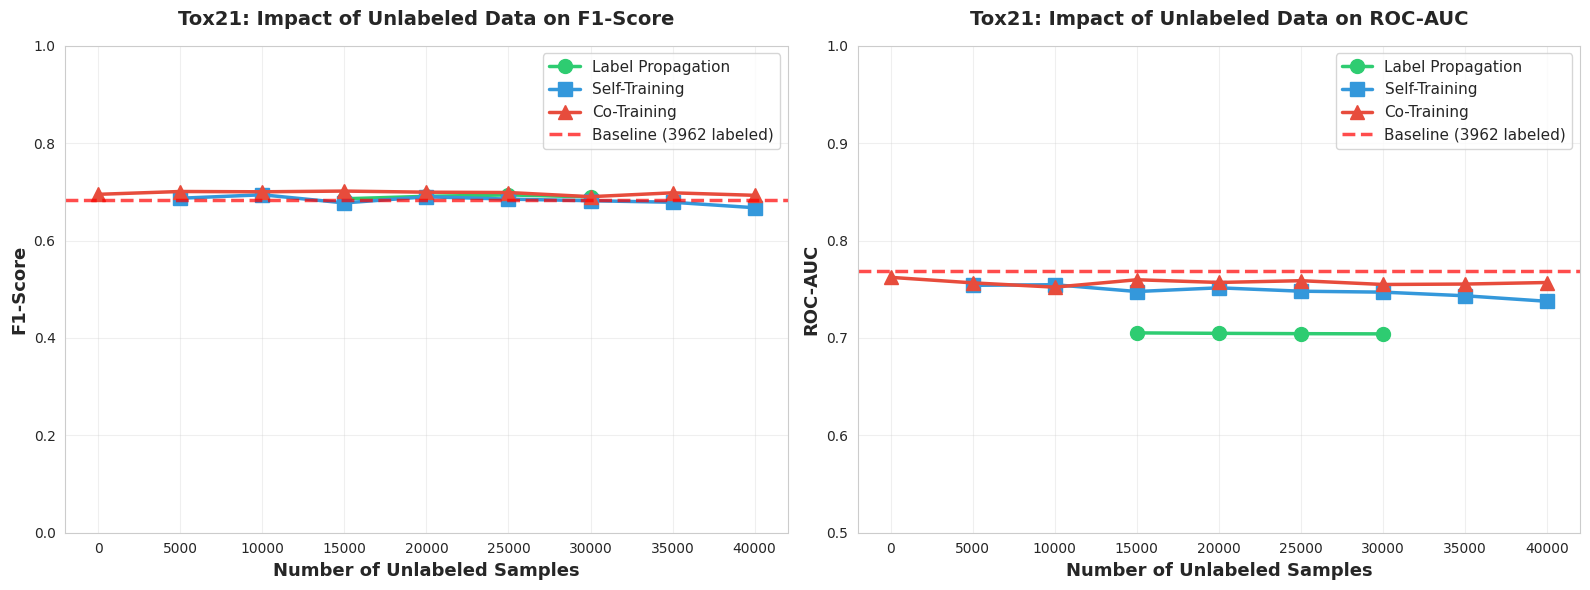


✓ Learning curves saved: tox21_learning_curves.png


In [ ]:
print("\n" + "="*100)
print("STEP 10: VISUALIZING LEARNING CURVES")
print("="*100)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

methods = {
    'Label Propagation': lp_df_tox,
    'Self-Training': st_df_tox,
    'Co-Training': ct_df_tox
}

colors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12']
markers = ['o', 's', '^', 'd']

for idx, (method_name, df_tox) in enumerate(methods.items()):
    if len(df_tox) > 0:
        axes[0].plot(df_tox['N_Unlabeled'], df_tox['F1-Score'],
                    marker=markers[idx], linewidth=2.5, markersize=10,
                    label=method_name, color=colors[idx])

axes[0].axhline(y=best_baseline_tox, color='red', linestyle='--', linewidth=2.5,
               label=f'Baseline ({len(X_train)} labeled)', alpha=0.7)
axes[0].set_xlabel('Number of Unlabeled Samples', fontsize=13, fontweight='bold')
axes[0].set_ylabel('F1-Score', fontsize=13, fontweight='bold')
axes[0].set_title('Tox21: Impact of Unlabeled Data on F1-Score',
                fontsize=14, fontweight='bold', pad=15)
axes[0].legend(loc='best', fontsize=11)
axes[0].grid(alpha=0.3)
axes[0].set_ylim([0, 1])

for idx, (method_name, df_tox) in enumerate(methods.items()):
    if len(df_tox) > 0:
        axes[1].plot(df_tox['N_Unlabeled'], df_tox['ROC-AUC'],
                    marker=markers[idx], linewidth=2.5, markersize=10,
                    label=method_name, color=colors[idx])

axes[1].axhline(y=baseline_roc_tox, color='red', linestyle='--', linewidth=2.5,
               label=f'Baseline ({len(X_train)} labeled)', alpha=0.7)
axes[1].set_xlabel('Number of Unlabeled Samples', fontsize=13, fontweight='bold')
axes[1].set_ylabel('ROC-AUC', fontsize=13, fontweight='bold')
axes[1].set_title('Tox21: Impact of Unlabeled Data on ROC-AUC',
                fontsize=14, fontweight='bold', pad=15)
axes[1].legend(loc='best', fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_ylim([0.5, 1])

plt.tight_layout()
plt.savefig('../../data/predictions/tox21/tox21_learning_curves.png', dpi=300)
plt.show()

print("\n✓ Learning curves saved: tox21_learning_curves.png")


STEP 11: BEST MODELS COMPARISON VISUALIZATION (Composite Score)

📊 Best Configuration per Method (Selected by Avg[F1, AUC]):
           Method  N_Unlabeled  Composite_Score  F1-Score  ROC-AUC  Accuracy
      Co-Training        15000         0.730737  0.701693 0.759781  0.699058
         Baseline            0         0.726116  0.683138 0.769095  0.697880
    Self-Training        10000         0.724395  0.694103 0.754687  0.706714
Label Propagation        25000         0.699113  0.693802 0.704424  0.610130


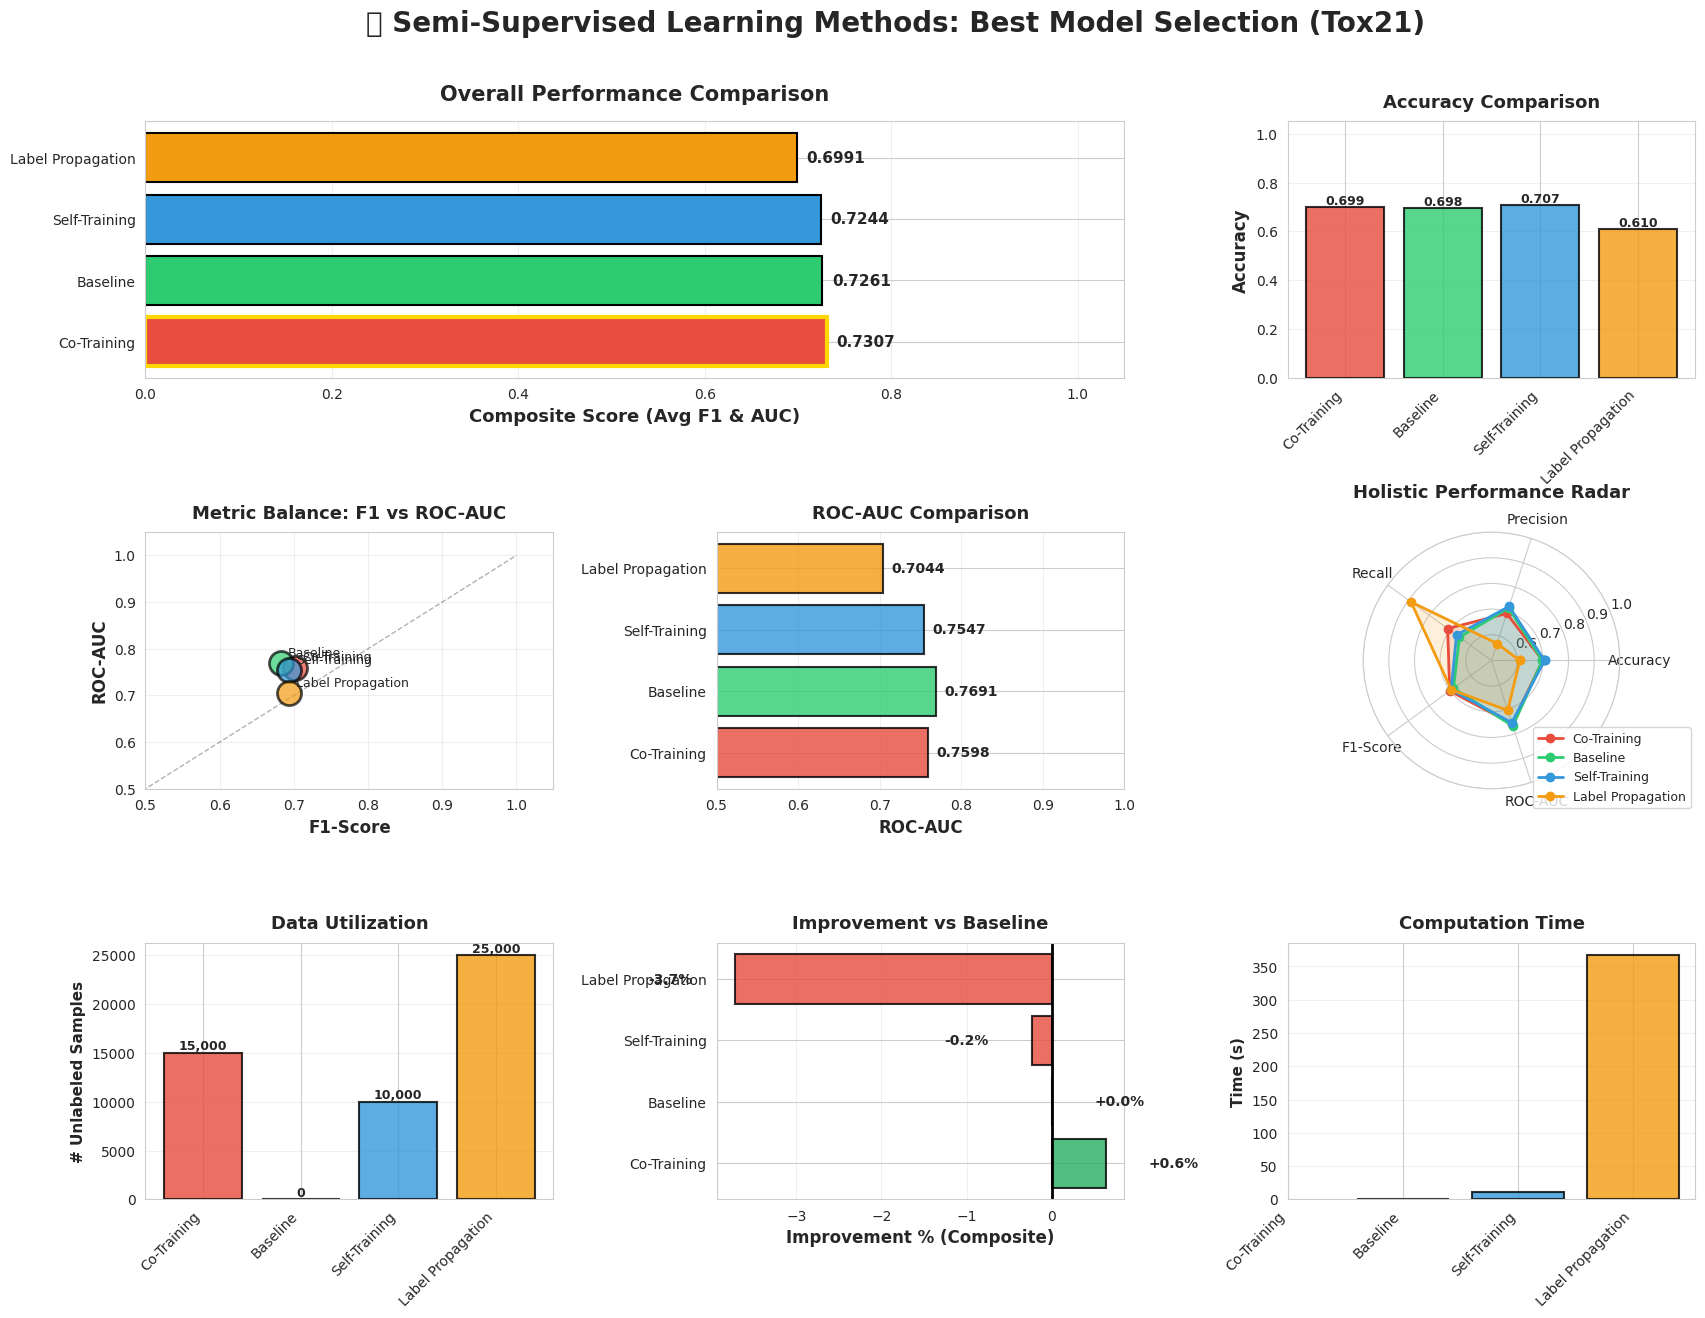


✓ Comparison saved to: ../../data/predictions/tox21/tox21_methods_comparison_balanced.png

📈 FINAL SELECTION SUMMARY (Tox21)

🥇 BEST OVERALL METHOD: Co-Training
   Composite Score: 0.7307
   F1-Score: 0.7017
   ROC-AUC:  0.7598
   Improvement over baseline: +0.64%

🏅 RANKINGS (by Composite Score)
🥇 Co-Training          - Avg: 0.7307 (F1: 0.7017)
🥈 Baseline             - Avg: 0.7261 (F1: 0.6831)
🥉 Self-Training        - Avg: 0.7244 (F1: 0.6941)
4️⃣ Label Propagation    - Avg: 0.6991 (F1: 0.6938)


In [ ]:
# Best Models Comparison Visualization (Balanced Metric)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("\n" + "="*100)
print("STEP 11: BEST MODELS COMPARISON VISUALIZATION (Composite Score)")
print("="*100)

baseline_metrics = baseline_df_tox.iloc[0]
baseline_f1 = baseline_metrics['F1-Score']
baseline_auc = baseline_metrics['ROC-AUC']
baseline_composite = (baseline_f1 + baseline_auc) / 2

baseline_row = pd.DataFrame([{
    'Method': 'Baseline',
    'N_Unlabeled': 0,
    'Accuracy': baseline_metrics['Accuracy'],
    'Precision': baseline_metrics['Precision'],
    'Recall': baseline_metrics['Recall'],
    'F1-Score': baseline_f1,
    'ROC-AUC': baseline_auc,
    'Composite_Score': baseline_composite,
    'Training_Time': baseline_metrics.get('Training_Time', 0)
}])

best_models_list = [baseline_row]
method_dfs = [
    ('Label Propagation', lp_df_tox),
    ('Self-Training', st_df_tox),
    ('Co-Training', ct_df_tox)
]

for method_name, df in method_dfs:
    if len(df) > 0:
        ssl_results = df[df['N_Unlabeled'] > 0].copy()
        if len(ssl_results) > 0:
            safe_auc = ssl_results['ROC-AUC'].fillna(ssl_results['F1-Score'])
            ssl_results['Composite_Score'] = (ssl_results['F1-Score'] + safe_auc) / 2
            best_idx = ssl_results['Composite_Score'].idxmax()
            best_row = ssl_results.loc[[best_idx]].copy()
            best_row['Method'] = method_name
            best_models_list.append(best_row)

best_models_df = pd.concat(best_models_list, ignore_index=True)
best_models_df = best_models_df.sort_values('Composite_Score', ascending=False).reset_index(drop=True)

print("\n📊 Best Configuration per Method (Selected by Avg[F1, AUC]):")
cols_to_show = ['Method', 'N_Unlabeled', 'Composite_Score', 'F1-Score', 'ROC-AUC', 'Accuracy']
print(best_models_df[cols_to_show].to_string(index=False))

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.6, wspace=0.4)
colors_palette = ['#e74c3c', '#2ecc71', '#3498db', '#f39c12', '#9b59b6']

# A. Composite Score
ax1 = fig.add_subplot(gs[0, :2])
methods_arr = best_models_df['Method'].values
scores = best_models_df['Composite_Score'].values
bars1 = ax1.barh(methods_arr, scores, color=colors_palette[:len(methods_arr)],
                edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Composite Score (Avg F1 & AUC)', fontsize=13, fontweight='bold')
ax1.set_title('Overall Performance Comparison', fontsize=15, fontweight='bold', pad=15)
ax1.set_xlim([0, 1.05])
ax1.grid(axis='x', alpha=0.3)
for bar, score in zip(bars1, scores):
    ax1.text(score + 0.01, bar.get_y() + bar.get_height()/2,
            f'{score:.4f}', va='center', fontweight='bold', fontsize=11)
best_idx = scores.argmax()
bars1[best_idx].set_edgecolor('gold')
bars1[best_idx].set_linewidth(3)

# B. Accuracy
ax2 = fig.add_subplot(gs[0, 2])
accuracies = best_models_df['Accuracy'].values
bars2 = ax2.bar(range(len(methods_arr)), accuracies,
               color=colors_palette[:len(methods_arr)],
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_xticks(range(len(methods_arr)))
ax2.set_xticklabels(methods_arr, rotation=45, ha='right', fontsize=10)
ax2.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('Accuracy Comparison', fontsize=13, fontweight='bold', pad=10)
ax2.set_ylim([0, 1.05])
ax2.grid(axis='y', alpha=0.3)
for bar, acc in zip(bars2, accuracies):
    ax2.text(bar.get_x() + bar.get_width()/2, acc + 0.01,
            f'{acc:.3f}', ha='center', fontweight='bold', fontsize=9)

# C. F1 vs ROC-AUC scatter
ax3 = fig.add_subplot(gs[1, 0])
f1s = best_models_df['F1-Score'].values
aucs = best_models_df['ROC-AUC'].values
for i, method in enumerate(methods_arr):
    ax3.scatter(f1s[i], aucs[i], s=300, color=colors_palette[i],
               edgecolor='black', linewidth=2, alpha=0.7, label=method, zorder=3)
    ax3.annotate(method, (f1s[i], aucs[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax3.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
ax3.set_ylabel('ROC-AUC', fontsize=12, fontweight='bold')
ax3.set_title('Metric Balance: F1 vs ROC-AUC', fontsize=13, fontweight='bold', pad=10)
ax3.grid(alpha=0.3)
ax3.set_xlim([0.5, 1.05])
ax3.set_ylim([0.5, 1.05])
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)

# D. ROC-AUC bars
ax4 = fig.add_subplot(gs[1, 1])
valid_roc = ~np.isnan(aucs)
if valid_roc.any():
    valid_methods = methods_arr[valid_roc]
    valid_aucs = aucs[valid_roc]
    valid_colors = [colors_palette[i] for i, v in enumerate(valid_roc) if v]
    bars4 = ax4.barh(valid_methods, valid_aucs, color=valid_colors,
                    edgecolor='black', linewidth=1.5, alpha=0.8)
    ax4.set_xlabel('ROC-AUC', fontsize=12, fontweight='bold')
    ax4.set_title('ROC-AUC Comparison', fontsize=13, fontweight='bold', pad=10)
    ax4.set_xlim([0.5, 1.0])
    ax4.grid(axis='x', alpha=0.3)
    for bar, auc in zip(bars4, valid_aucs):
        ax4.text(auc + 0.01, bar.get_y() + bar.get_height()/2,
                f'{auc:.4f}', va='center', fontweight='bold', fontsize=10)
else:
    ax4.text(0.5, 0.5, 'ROC-AUC not available', ha='center', va='center')

# E. Radar chart
ax5 = fig.add_subplot(gs[1, 2], projection='polar')
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
angles = np.linspace(0, 2 * np.pi, len(metrics_names), endpoint=False).tolist()
angles += angles[:1]
for i, method in enumerate(methods_arr):
    values = [
        best_models_df.iloc[i]['Accuracy'],
        best_models_df.iloc[i]['Precision'],
        best_models_df.iloc[i]['Recall'],
        best_models_df.iloc[i]['F1-Score'],
        best_models_df.iloc[i]['ROC-AUC']
    ]
    values = [v if not np.isnan(v) else 0.5 for v in values]
    values += values[:1]
    ax5.plot(angles, values, 'o-', linewidth=2, label=method, color=colors_palette[i])
    ax5.fill(angles, values, alpha=0.15, color=colors_palette[i])
ax5.set_xticks(angles[:-1])
ax5.set_xticklabels(metrics_names, fontsize=10)
ax5.set_ylim(0.5, 1)
ax5.set_title('Holistic Performance Radar', fontsize=13, fontweight='bold', pad=25)
ax5.legend(loc='lower right', bbox_to_anchor=(1.3, -0.1), fontsize=9)
ax5.grid(True)

# F. Unlabeled usage
ax6 = fig.add_subplot(gs[2, 0])
n_unlabeled = best_models_df['N_Unlabeled'].values
bars6 = ax6.bar(range(len(methods_arr)), n_unlabeled,
               color=colors_palette[:len(methods_arr)],
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax6.set_xticks(range(len(methods_arr)))
ax6.set_xticklabels(methods_arr, rotation=45, ha='right', fontsize=10)
ax6.set_ylabel('# Unlabeled Samples', fontsize=11, fontweight='bold')
ax6.set_title('Data Utilization', fontsize=13, fontweight='bold', pad=10)
ax6.grid(axis='y', alpha=0.3)
for bar, n in zip(bars6, n_unlabeled):
    if max(n_unlabeled) > 0:
        ax6.text(bar.get_x() + bar.get_width()/2, n,
                f'{int(n):,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# G. Improvement vs baseline
ax7 = fig.add_subplot(gs[2, 1])
baseline_score = best_models_df[best_models_df['Method'] == 'Baseline']['Composite_Score'].values[0]
improvements = ((best_models_df['Composite_Score'].values - baseline_score) / baseline_score) * 100
bars7 = ax7.barh(methods_arr, improvements,
                color=colors_palette[:len(methods_arr)],
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax7.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax7.set_xlabel('Improvement % (Composite)', fontsize=12, fontweight='bold')
ax7.set_title('Improvement vs Baseline', fontsize=13, fontweight='bold', pad=10)
ax7.grid(axis='x', alpha=0.3)
for bar, imp in zip(bars7, improvements):
    color = '#27ae60' if imp > 0 else ('#e74c3c' if imp < 0 else '#95a5a6')
    bar.set_facecolor(color)
    ax7.text(imp + (0.5 if imp >= 0 else -0.5), bar.get_y() + bar.get_height()/2,
            f'{imp:+.1f}%', va='center', fontweight='bold', fontsize=10,
            ha='left' if imp >= 0 else 'right')

# H. Training time
ax8 = fig.add_subplot(gs[2, 2])
train_times = best_models_df.get('Training_Time', pd.Series([0]*len(best_models_df))).values
bars8 = ax8.bar(range(len(methods_arr)), train_times,
               color=colors_palette[:len(methods_arr)],
               edgecolor='black', linewidth=1.5, alpha=0.8)
ax8.set_xticks(range(len(methods_arr)))
ax8.set_xticklabels(methods_arr, rotation=45, ha='right', fontsize=10)
ax8.set_ylabel('Time (s)', fontsize=11, fontweight='bold')
ax8.set_title('Computation Time', fontsize=13, fontweight='bold', pad=10)
ax8.grid(axis='y', alpha=0.3)
for bar, t in zip(bars8, train_times):
    ax8.text(bar.get_x() + bar.get_width()/2, t + max(train_times)*0.02 if len(train_times) else 0.01,
            f'{t:.2f}s', ha='center', fontweight='bold', fontsize=9)

fig.suptitle('🏆 Semi-Supervised Learning Methods: Best Model Selection (Tox21)',
            fontsize=20, fontweight='bold', y=0.96)

plt.savefig('../../data/predictions/tox21/tox21_methods_comparison_balanced.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison saved to: ../../data/predictions/tox21/tox21_methods_comparison_balanced.png")

print(f"\n{'='*100}")
print("📈 FINAL SELECTION SUMMARY (Tox21)")
print(f"{'='*100}")

best_method = best_models_df.iloc[0]
print(f"\n🥇 BEST OVERALL METHOD: {best_method['Method']}")
print(f"   Composite Score: {best_method['Composite_Score']:.4f}")
print(f"   F1-Score: {best_method['F1-Score']:.4f}")
print(f"   ROC-AUC:  {best_method['ROC-AUC']:.4f}")
print(f"   Improvement over baseline: {((best_method['Composite_Score'] - baseline_score) / baseline_score) * 100:+.2f}%")

print(f"\n{'='*100}")
print("🏅 RANKINGS (by Composite Score)")
print(f"{'='*100}")
for rank, (idx, row) in enumerate(best_models_df.iterrows(), 1):
    medal = ['🥇', '🥈', '🥉', '4️⃣', '5️⃣'][rank-1] if rank <= 5 else f'{rank}.'
    print(f"{medal} {row['Method']:20s} - Avg: {row['Composite_Score']:.4f} (F1: {row['F1-Score']:.4f})")

In [ ]:
print("\n" + "="*100)
print("STEP 12: SAVING FINAL RESULTS (Composite Score Based)")
print("="*100)
import os
output_dir = '../../data/predictions/tox21/'
os.makedirs(output_dir, exist_ok=True)

if 'Composite_Score' not in all_results_tox.columns:
    auc_filled = all_results_tox['ROC-AUC'].fillna(0.5)
    all_results_tox['Composite_Score'] = (all_results_tox['F1-Score'] + auc_filled) / 2

all_results_tox.to_csv(f'{output_dir}ssl_results_tox21.csv', index=False)
print("✓ Results saved: ssl_results_tox21.csv")

ssl_only = all_results_tox[all_results_tox['Method'] != 'Baseline'].copy()
if len(ssl_only) > 0:
    best_ssl_tox = ssl_only.sort_values('Composite_Score', ascending=False).iloc[0]
else:
    best_ssl_tox = all_results_tox.sort_values('Composite_Score', ascending=False).iloc[0]
    print("⚠️  No SSL results found. Using baseline as best model.")

print(f"\n✓ Best SSL model identified: {best_ssl_tox['Method']} (n={int(best_ssl_tox.get('N_Unlabeled', 0)):,})")
print(f"  Composite Score: {best_ssl_tox['Composite_Score']:.4f}")
print(f"  (F1: {best_ssl_tox['F1-Score']:.4f} | AUC: {best_ssl_tox['ROC-AUC']:.4f})")

baseline_metrics = baseline_df_tox.iloc[0]
baseline_f1 = baseline_metrics['F1-Score']
baseline_roc = baseline_metrics['ROC-AUC']
baseline_composite = (baseline_f1 + baseline_roc) / 2

imp_f1 = ((best_ssl_tox['F1-Score'] - baseline_f1) / baseline_f1) * 100
imp_composite = ((best_ssl_tox['Composite_Score'] - baseline_composite) / baseline_composite) * 100
imp_roc = ((best_ssl_tox['ROC-AUC'] - baseline_roc) / baseline_roc) * 100 if not np.isnan(best_ssl_tox['ROC-AUC']) else 0.0

summary = {
    'experiment_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'experiment_type': 'Tox21 Toxicity Prediction (Semi-Supervised)',
    'training_setup': {
        'n_labeled_total': len(X_full),
        'n_labeled_train': len(X_train),
        'n_test': len(X_test),
        'unlabeled_sizes_tested': [int(x) for x in unlabeled_sizes if x > 0],
        'stratified_sampling': True,
        'metric_used_for_selection': 'Composite Score (Avg of F1 & ROC-AUC)'
    },
    'best_model_tox': {
        'method': best_ssl_tox['Method'],
        'name': best_ssl_tox.get('Model', 'Unknown'),
        'n_unlabeled_used': int(best_ssl_tox.get('N_Unlabeled', 0)),
        'composite_score': float(best_ssl_tox['Composite_Score']),
        'f1_score': float(best_ssl_tox['F1-Score']),
        'accuracy': float(best_ssl_tox['Accuracy']),
        'precision': float(best_ssl_tox['Precision']),
        'recall': float(best_ssl_tox['Recall']),
        'roc_auc': float(best_ssl_tox['ROC-AUC']) if not np.isnan(best_ssl_tox['ROC-AUC']) else None,
        'baseline_composite': float(baseline_composite),
        'improvement_composite_pct': float(imp_composite),
        'improvement_f1_pct': float(imp_f1),
        'improvement_roc_pct': float(imp_roc),
        'training_time': float(best_ssl_tox.get('Training_Time', 0))
    },
    'methods_tested': [
        'Baseline (Supervised RF)',
        'Label Propagation',
        'Label Spreading',
        'Self-Training',
        'Co-Training'
    ],
    'key_findings': [
        f"Best Method: {best_ssl_tox['Method']} with {int(best_ssl_tox.get('N_Unlabeled', 0)):,} unlabeled samples.",
        f"Composite Score improved by {imp_composite:+.2f}% (from {baseline_composite:.4f} to {best_ssl_tox['Composite_Score']:.4f}).",
        f"F1-Score improved by {imp_f1:+.2f}%.",
        "Demonstrates utility of unlabeled data for toxicity prediction."
    ]
}

with open(f'{output_dir}ssl_summary_tox21.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✓ Summary saved: ssl_summary_tox21.json")

print(f"\n{'='*100}")
print("ALL RESULTS SAVED SUCCESSFULLY")
print(f"{'='*100}")
print(f"📁 Location: {output_dir}")
print(f"   • ssl_results_tox21.csv")
print(f"   • ssl_summary_tox21.json")


STEP 12: SAVING FINAL RESULTS (Composite Score Based)
✓ Results saved: ssl_results_tox21.csv

✓ Best SSL model identified: Co-Training (n=15,000)
  Composite Score: 0.7307
  (F1: 0.7017 | AUC: 0.7598)
✓ Summary saved: ssl_summary_tox21.json

ALL RESULTS SAVED SUCCESSFULLY
📁 Location: ../../data/predictions/tox21/
   • ssl_results_tox21.csv
   • ssl_summary_tox21.json
